In [12]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display, clear_output
from PIL import Image, ImageSequence
import os

import seaborn as sea

In [71]:
def create_loss_manifold(sigfrac, m1, m2, z):

    start = 0.5
    end = 6
    step = 0.25

    weight_list = np.arange(start, end + step, step)

    grid_axes = []
    for w1 in weight_list:
        for w2 in weight_list:
            grid_axes.append((w1, w2))

    w1_values, w2_values = zip(*grid_axes)

    loss_values = list(z[sigfrac, m1, m2])

    x = w1_values
    y = w2_values
    z = loss_values

    sea.set(style="whitegrid")
    fig = plt.figure(figsize = (10,8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x, y, z, c='r', marker='.', alpha = 0.1)
    ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='none')

    ax.set_xlabel('W1')
    ax.set_ylabel('W2')
    ax.set_zlabel('Loss')
    ax.set_title("Loss Manifold m1: {} m2: {} sigfrac: {}".format(m1, m2, np.round(sigfrac, 4)))

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    ax.grid(False)
    
    #ax.set_xticks([])
    #ax.set_yticks([])
    ax.set_zticks([])
    
    ax.view_init(elev=50, azim=10)
    return ax

In [20]:
z_allm1m2_4HD = np.load("z_allm1m2_4FeaturesHD.npy", allow_pickle = True).item()
z_allm1m2_4HD.keys()

dict_keys([(0.001, 3, 4.5), (0.0012742749857031334, 3, 4.5), (0.001623776739188721, 3, 4.5), (0.00206913808111479, 3, 4.5), (0.0026366508987303583, 3, 4.5), (0.003359818286283781, 3, 4.5), (0.004281332398719396, 3, 4.5), (0.00545559478116852, 3, 4.5), (0.0069519279617756054, 3, 4.5), (0.008858667904100823, 3, 4.5), (0.011288378916846888, 3, 4.5), (0.01438449888287663, 3, 4.5), (0.018329807108324356, 3, 4.5), (0.023357214690901212, 3, 4.5), (0.029763514416313176, 3, 4.5), (0.0379269019073225, 3, 4.5), (0.04832930238571752, 3, 4.5), (0.06158482110660261, 3, 4.5), (0.07847599703514611, 3, 4.5), (0.1, 3, 4.5), (0.001, 1, 5.5), (0.0012742749857031334, 1, 5.5), (0.001623776739188721, 1, 5.5), (0.00206913808111479, 1, 5.5), (0.0026366508987303583, 1, 5.5), (0.003359818286283781, 1, 5.5), (0.004281332398719396, 1, 5.5), (0.00545559478116852, 1, 5.5), (0.0069519279617756054, 1, 5.5), (0.008858667904100823, 1, 5.5), (0.011288378916846888, 1, 5.5), (0.01438449888287663, 1, 5.5), (0.01832980710832

In [15]:
z_allm1m2_6HD = np.load("z_allm1m2_6FeaturesHD.npy", allow_pickle = True).item()
z_allm1m2_6HD.keys()

dict_keys([(0.0379269019073225, 3, 4.5), (0.001, 3, 4.5), (0.0012742749857031334, 3, 4.5), (0.001623776739188721, 3, 4.5), (0.00206913808111479, 3, 4.5), (0.0026366508987303583, 3, 4.5), (0.003359818286283781, 3, 4.5), (0.004281332398719396, 3, 4.5), (0.00545559478116852, 3, 4.5), (0.0069519279617756054, 3, 4.5), (0.008858667904100823, 3, 4.5), (0.011288378916846888, 3, 4.5), (0.01438449888287663, 3, 4.5), (0.018329807108324356, 3, 4.5), (0.023357214690901212, 3, 4.5), (0.029763514416313176, 3, 4.5), (0.04832930238571752, 3, 4.5), (0.06158482110660261, 3, 4.5), (0.07847599703514611, 3, 4.5), (0.1, 3, 4.5), (0.001, 3, 3), (0.0012742749857031334, 3, 3), (0.001623776739188721, 3, 3), (0.00206913808111479, 3, 3), (0.0026366508987303583, 3, 3), (0.003359818286283781, 3, 3), (0.004281332398719396, 3, 3), (0.00545559478116852, 3, 3), (0.0069519279617756054, 3, 3), (0.008858667904100823, 3, 3), (0.011288378916846888, 3, 3), (0.01438449888287663, 3, 3), (0.018329807108324356, 3, 3), (0.02335721

<Axes3D: title={'center': 'Loss Manifold m1: 1 m2: 5.5 sigfrac: 0.1'}, xlabel='W1', ylabel='W2', zlabel='Loss'>

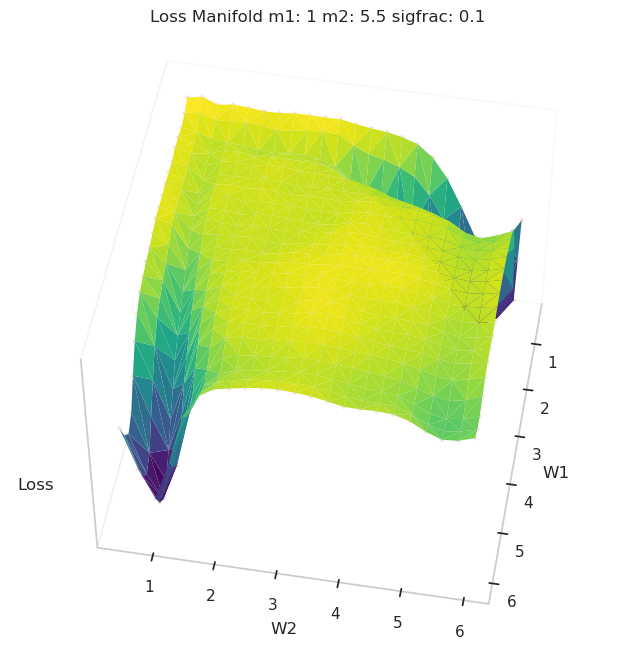

In [74]:
sig_space = np.logspace(-3, -1 , 20)
create_loss_manifold(sig_space[19], 1, 5.5, z_allm1m2_4HD)

<Axes3D: title={'center': 'Loss Manifold m1: 1 m2: 5.5 sigfrac: 0.1'}, xlabel='W1', ylabel='W2', zlabel='Loss'>

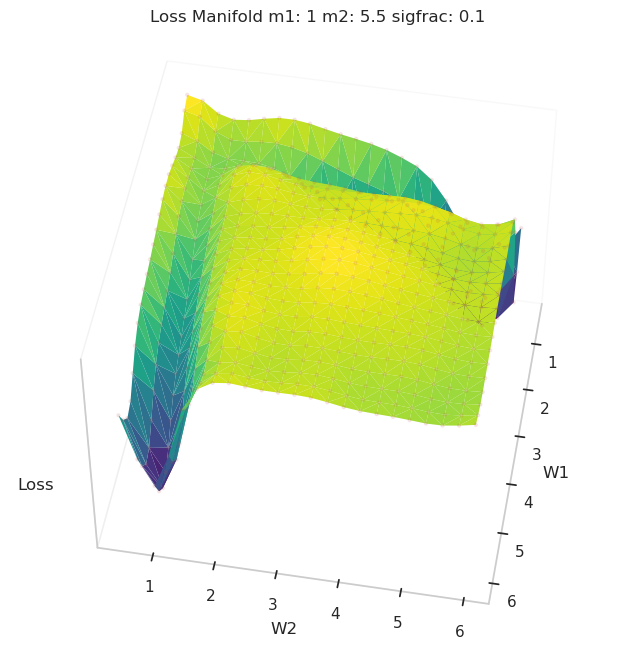

In [72]:
sig_space = np.logspace(-3, -1 , 20)
create_loss_manifold(sig_space[19], 1, 5.5, z_allm1m2_6HD)

In [54]:
def create_gif_manifold(m1, m2, z):
    
    output_directory = '2dhist_images'
    os.makedirs(output_directory, exist_ok=True)
    
    sig_space = np.logspace(-3, -1 , 20)
    
    frames = []
    for sig in sig_space:
    
        create_3D_loss_manifold(sb, m1, m2, z)

        image_path = os.path.join(output_directory, f'hist_{sig}.png')
        plt.savefig(image_path)
        plt.close()
        clear_output(wait=True)

        frames.append(Image.open(image_path))

    output_gif_filename = f'LossManifoldformated{m1}{m2}.gif'
    frames[0].save(output_gif_filename, save_all=True, append_images=frames[1:], duration=400, loop=0)

In [55]:
create_gif_manifold(3, 4.5, z_allm1m2_4HD)